# Introdução às Redes Neurais Fisicamente Informadas - PINNs (Dia 05) Picture1.jpg

---
**EXEMPLO 1**

**Objetivo:** resolver a EDO $$\dfrac{du}{dt}=\cos \pi t$$
com condição inicial $u(0)=1.$

Para esse problema a solução exata é conhecida, basta integrar, e é dada por $$u(t)=\frac{1}{2\pi} \sin 2\pi t +1.$$

Para resolver esse problema iremos construir uma rede neural com as características da imagem abaixo e usaremos o `tensorflow` para este fim.



---
Começamos importando as bibliotecas necessárias e aqui usaremos o TensorFlow 2.0/Keras

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import random

---
Agora fixamos a semente, para que as soluções possam ser reproduzidas.

In [2]:
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

---
Montamos a arquitetura da rede neural: 2 camadas escondidas com 60 neurônios usando a tangente hiperbólica como função de ativação.

In [3]:
NN = tf.keras.models.Sequential([
    tf.keras.layers.Input((1,)),
    tf.keras.layers.Dense(units = 60, activation = 'tanh'),
    tf.keras.layers.Dense(units = 60, activation = 'tanh'),
    tf.keras.layers.Dense(units = 1)
])

NN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 60)             │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 60)             │         3,660 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,841 (15.00 KB)

 Trainable params: 3,841 (15.00 KB)

 Non-trainable params: 0 (0.00 B)

---
Escolhemos agora o nosso o otimizador como o ADAM com uma taxa de aprendizagem de `lr=1e-3`.

In [4]:
optm = tf.keras.optimizers.Adam(learning_rate = 0.001)

---
Construindo a função de perda particular para o nosso problema.

Função de perda da EDO: $$L_{\text{ode}}=\frac{1}{n}\sum_{i=1}^{n}\left(\frac{dNN(t_{i})}{dt}-\cos2\pi t_{i}\right)^{2}$$
Função de perda da condição inicial: $$L_{\text{ic}}=\left(NN(0)-1\right)^{2}$$
Função de perda total: $$L_{\text{Total}}=L_{\text{ode}}+L_{\text{ic}}$$

In [5]:
def ode_system(t, net):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)
    t_0 = tf.zeros((1,1)) # instante inicial
    one = tf.ones((1,1))

    with tf.GradientTape() as tape:
        tape.watch(t)

        u = net(t)
        u_t = tape.gradient(u, t) # calcula a derivada da rede com relação a variável t

    ode_loss = u_t - tf.math.cos(2*np.pi*t) # função de perda da EDO
    IC_loss = net(t_0) - one # função de perda da condição inicial

    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss) # calcula a perda total

    return total_loss

---
**Treinamento da rede!**

O intervalo em que a EDO será resolvida é $[0,2]$. A quantidade de pontos internos escolhidos nesse intervalo é $n=50$ e eles serão amostrados aleatoriamente usando a distribuição uniforme.

Época 0, Perda: 1.507946491241455
Época 1000, Perda: 0.001989671727642417
Época 2000, Perda: 0.0005895466892980039
Época 3000, Perda: 0.0005696945590898395
Época 4000, Perda: 0.00040562686626799405
Época 5000, Perda: 0.00036416362854652107


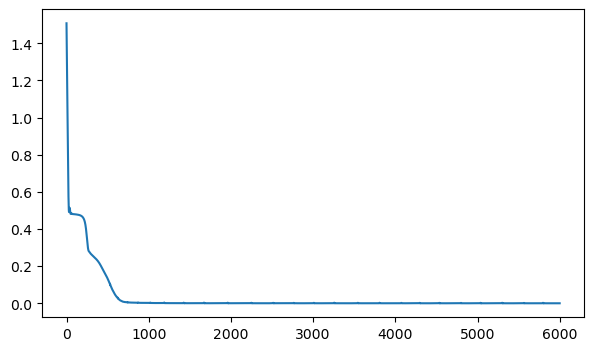

In [6]:
epocas = 6000

# collocation points
train_t = (np.random.rand(50)*2).reshape(-1, 1) # definindo os pontos no domínio e que serão utilizados para treino

train_loss_record = []

for epoch in range(epocas):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if epoch % 1000 == 0:
        print(f'Época {epoch}, Perda: {train_loss.numpy()}')

# imprime o gráfico da perda com relação as épocas
plt.figure(figsize = (7,4))
plt.plot(train_loss_record)
plt.show()

---
Faz os gráficos das soluções analítica e numérica para comparação.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


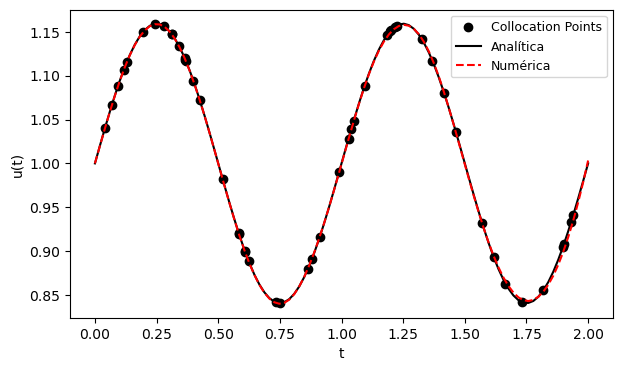

In [7]:
test_t = np.linspace(0, 2, 100)

train_u = np.sin(2*np.pi*train_t)/(2*np.pi) + 1
true_u = np.sin(2*np.pi*test_t)/(2*np.pi) + 1
pred_u = NN.predict(test_t).ravel()

plt.figure(figsize = (7,4))
plt.plot(train_t, train_u, 'ok', label = 'Collocation Points')
plt.plot(test_t, true_u, '-k',label = 'Analítica')
plt.plot(test_t, pred_u, '--r', label = 'Numérica')
plt.legend(fontsize = 9)
plt.xlabel('t', fontsize = 10)
plt.ylabel('u(t)', fontsize = 10)
plt.show()

---
**EXEMPLO 2**

**Objetivo:** resolver a EDO $$\dfrac{du}{dt}+\frac{1}{t}u=1$$
com condição inicial $u(1)=1$, no intervalo $[1,3]$.

Para esse problema a solução exata é também conhecida e pode ser calculda usando o método do fator integrante para obter é dada por $$u(t)=\frac{t^2+1}{2t}.$$

Para resolver esse problema vamos reusar o código anterior apenas com as alterações necessárias.



---
Aqui modificamos, na função `ode_system()` a EDO, condição inicial e função de perda que vamos utilizar.

In [8]:
def ode_system(t, net):
    t = t.reshape(-1,1)
    t = tf.constant(t, dtype = tf.float32)
    t_0 = tf.ones((1,1))
    one = tf.ones((1,1))

    with tf.GradientTape() as tape:
        tape.watch(t)

        u = net(t)
        u_t = tape.gradient(u, t)

    ode_loss = u_t + (1/t)*u - 1 # u'+u/t=1
    IC_loss = net(t_0) - one # u(1)=1

    square_loss = tf.square(ode_loss) + tf.square(IC_loss)
    total_loss = tf.reduce_mean(square_loss)

    return total_loss

---
**Treinamento da rede!**

Neste exemplo, o intervalo em que a EDO será resolvida é $[1,3]$. A quantidade de pontos internos escolhidos nesse intervalo é $n=30$ e, novamente, eles serão amostrados aleatoriamente usando a distribuição uniforme.

Época 0, Perda: 1.716658115386963
Época 1000, Perda: 0.00023846325348131359
Época 2000, Perda: 3.192523217876442e-05
Época 3000, Perda: 1.5507222997257486e-05
Época 4000, Perda: 3.577737288651406e-06
Época 5000, Perda: 1.2011521448584972e-06


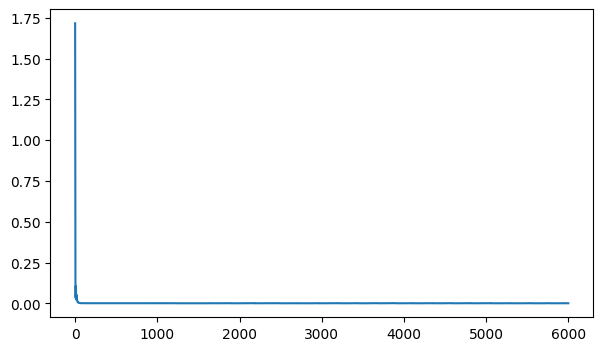

In [9]:
train_t = (np.random.rand(30)*2+1).reshape(-1, 1) # a função rand() gera números no intervalo [0,1]

train_loss_record = []

for epoch in range(epocas):
    with tf.GradientTape() as tape:
        train_loss = ode_system(train_t, NN)
        train_loss_record.append(train_loss)

        grad_w = tape.gradient(train_loss, NN.trainable_variables)
        optm.apply_gradients(zip(grad_w, NN.trainable_variables))

    if epoch % 1000 == 0:
        print(f'Época {epoch}, Perda: {train_loss.numpy()}')

# imprime o gráfico da perda com relação as épocas
plt.figure(figsize = (7,4))
plt.plot(train_loss_record)
plt.show()

---
Finalmente, vamos mostrar as soluções numérica e analítica para efeito de comparação.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


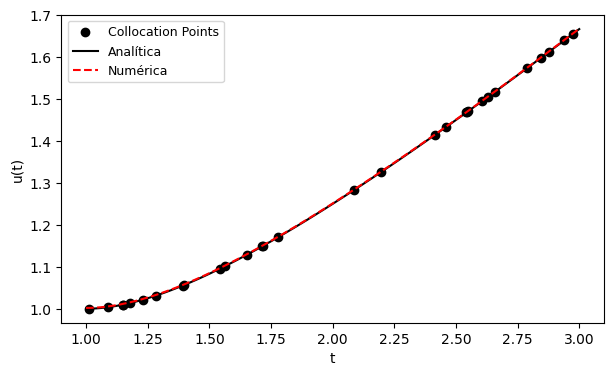

In [10]:
test_t = np.linspace(1, 3, 100)

train_u = (train_t*train_t+1)/(2*train_t)
true_u = (test_t*test_t+1)/(2*test_t)
pred_u = NN.predict(test_t).ravel()

plt.figure(figsize = (7,4))
plt.plot(train_t, train_u, 'ok', label = 'Collocation Points')
plt.plot(test_t, true_u, '-k',label = 'Analítica')
plt.plot(test_t, pred_u, '--r', label = 'Numérica')
plt.legend(fontsize = 9)
plt.xlabel('t', fontsize = 10)
plt.ylabel('u(t)', fontsize = 10)
plt.show()